In [1]:
from datasets import load_dataset
from LatentPixel import LatentLlama, TGraph, BIN_FONT
from tqdm import tqdm

/home/tai/miniconda3/envs/pt2hfpy310/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/tai/miniconda3/envs/pt2hfpy310/lib/python3.10/site-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(


In [2]:
data = load_dataset('lambada', split='test')
TGraph.init_render(
    dpi=80,
    font_file=BIN_FONT,
    font_size=8,
    pixels_per_patch=8,
    rgb=False,
    binary=True,
    max_seq_length=800,
    patch_len=2
)
model = LatentLlama(
    backbone_path='storage/llama_2_backbone/',
    num_channels=1,
    patch_len=2,
    patch_size=8,
    binary=True
)

Found cached dataset lambada (/mnt/data/huggingface/lambada/plain_text/1.1.0/2e4879aaaa342d8f748b7275991006d2e27a8b0abc0a28ea299b3e3b839a3a40)


Coder path is none, do not load compressor for this model


Some weights of LlamaForPatchCausalInference were not initialized from the model checkpoint at storage/llama_2_backbone/ and are newly initialized: ['embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
def process_lambda(raw: str) -> str:
    raw = raw.replace('`` ', '"').replace(" ''", '"').replace('``', '"').replace("''", '"')
    result = ''
    for idx in range(len(raw) - 1):
        c = raw[idx]
        cn = raw[idx + 1]
        if cn in ',.?><{}()\'' and c == ' ':
            continue
        if (raw[idx+1:idx+4] == "n't" or raw[idx+1:idx+4] == "'re" or raw[idx+1:idx+3] == "'d" or raw[idx+1:idx+3] == "'s" or raw[idx+1:idx+3] == "'m") and raw[idx] == ' ':
            continue
        if raw[idx+1] == "'" and raw[idx+2] in 'abcdefghijklmnopqrstuvwxyz' and raw[idx] == ' ':
            continue
        result += raw[idx]
    result += raw[-1]
    return result

In [52]:
model.eval()
generated = []
for txt in tqdm(data['text'][0:200]):
    words = txt.split()
    prompt = process_lambda(' '.join(words[:-1]))
    prompt = TGraph.from_text([prompt])
    prompt = prompt._spacing_text(3)
    target = words[-1]
    gen = model.autoregressive_generate(prompt, None, 4)
    generated.append((prompt, target, gen))

100%|██████████| 200/200 [03:08<00:00,  1.06it/s]


['was natasha annoyed with axel? amused? merely being factual? it was impossible to guess. tone of voice, inflection, the subtle melody and rhythm of ordinary speech : all of these were missing. the voice-synth was like a piano that could play only one note. "i neglected to tell you natasha was coming," i said to']
axel


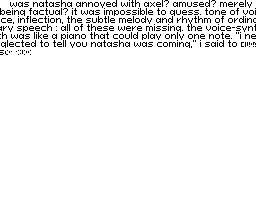

In [451]:
idx = 166
print(generated[idx][0].text)
print(generated[idx][1])
generated[idx][2].to_PIL()[0]

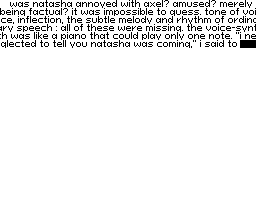

In [452]:
generated[idx][0].to_PIL()[0]

In [453]:
capital = '1 3 5 7 8 17 19 21 23 24 26 29 30 31 33 36 38 40 41 43 48 55 57 58 59 60 61 62 65 70 72 74 76 79 80 81 82 87 88 90 93 95 96 97 99 101 104 106 110 112 115 116 117 118 120 121 122 124 126 131 132 134 138 139 141 143 145 147 148 149 150 151 154 155 157 159 160 162 164 165 166 167 172 174 176 180 181 183 186 187 189 191 192 195 197 198 199'
wrong_word = '19 21 24 58 81 88 106 182 184'
correct = '2 4 20 35 63 111 141 145 158'
non_text = '0 1 3 5 6 7 8 9 10 11 12 13 14 15 16 17 18 22 23 25 26 27 28 29 30 31 32 33 34 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 59 60 61 62 64 65 66 67 68 69 70 72 71 73 74 75 76 77 78 79 80 82 83 84 85 86 87 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 107 108 109 110 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 142 143 144 146 147 148 149 150 151 152 153 154 155 156 157 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 183 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199'

In [454]:
capitals = set(capital.split(' '))
wrong_words = set(wrong_word.split(' '))
corrects = set(correct.split(' '))
non_texts = set(non_text.split(' '))

In [461]:
print('Acc: ', len(corrects) / 200)
print('Wrong: ', len(wrong_words) / 200)
print('Acc_no_cap: ', len(corrects - capitals) / (200 - len(capitals)))
print('Wrong_no_cap: ', len(wrong_words - capitals) / (200 - len(capitals)))
print('Non_text: ', len(non_texts) / 200)
print('Non_text_no_cap: ', len(non_texts - capitals) / (200 - len(capitals)))
print('Num_no_cap: ', (200 - len(capitals)))
print('Num_total: ', 200)

Acc:  0.045
Wrong:  0.045
Acc_no_cap:  0.06796116504854369
Wrong_no_cap:  0.019417475728155338
Non_text:  0.91
Non_text_no_cap:  0.912621359223301
Num_no_cap:  103
Num_total:  200


In [445]:
total = (list(wrong_words) + list(corrects) + list(non_texts))
total = list(map(lambda x: int(x), total))
total.sort()
print(total)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]


In [446]:
set(range(200)) - set(total)

{70, 72, 166}